# Классификация изображений

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import random
import torch
from torch import nn
from torch import optim
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, random_split

In [18]:
DEVICE = torch.device('cuda')
SEED = 10

random.seed(SEED)               # Python's built-in random module
np.random.seed(SEED)            # NumPy
torch.manual_seed(SEED)         # PyTorch CPU
torch.cuda.manual_seed(SEED)    # PyTorch GPU
torch.cuda.manual_seed_all(SEED)

## 1/ Датасет
- Данные удобно разбиты по папкам, поэтому можем сразу применить [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html#imagefolder:~:text=ImageFolder-,ImageFolder,-CLASS) от torchvision
- Будем использовать [стандарт ImageNet](https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2) для mean/std
- Разделим на обучающую/тестовую выборку в соотношении 75/25

In [30]:
DATA_DIRECTORY = '/kaggle/input/animal-image-dataset-cats-dogs-and-foxes/Animal Image Dataset-Cats, Dogs, and Foxes'

TRANSFORMATIONS = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=DATA_DIRECTORY,
                               transform=TRANSFORMATIONS)

In [31]:
BATCH_SIZE = 32

train_size = int(0.7 * len(dataset))
test_size = int(0.15 * len(dataset))
valid_size = len(dataset) - train_size - test_size

# рандомно делим данные в указанном соотношении на train/test
train_dataset, test_dataset, valid_dataset = random_split(dataset, [train_size, test_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Данных для обучения: {train_size}")
print(f"Данных для тестирования: {test_size}")
print(f"Данных для валидации: {valid_size}")

Данных для обучения: 215
Данных для тестирования: 46
Данных для валидации: 47


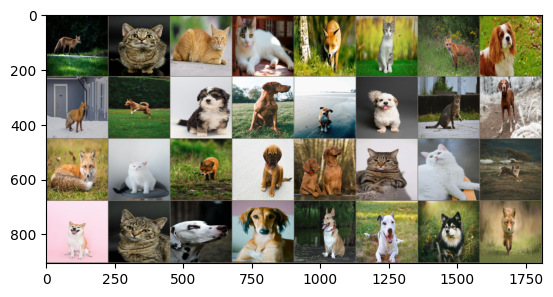

In [32]:
def show_grid(img):
    npimg = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    denormalized_img = std * npimg + mean
    
    plt.imshow(denormalized_img)
    plt.show()
    
# батч для визуализации
dataiter = iter(train_loader)
images, labels = next(dataiter)

# отображаем
show_grid(make_grid(images))

## 2/ Модель и гиперпараметры

- В качестве модели будем использовать `resnet` (он часто baseline в задачах классификации, т.к. обучался на ImageNet)
- В качестве функции потерь используем классическую кросс-энтропию
- В качестве оптимизатора возьмем SGD

In [33]:
# МОДЕЛЬ
# 1) загрузим модель с обученными весами
# 2) заморозим веса, чтобы они уже не менялись
# 3) добавил линейный слой для нашей задачи (тут веса будем обучать)
model = models.resnet50(pretrained=True)
model = model.to(DEVICE)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # у нас 3 класса: собаки, кошки, лисы

In [34]:
# функция потерь
criterion = nn.CrossEntropyLoss()
# оптимизатор
optimizer = optim.SGD(model.fc.parameters(), lr=1e-3, momentum=0.75)

## 4/ Обучение модели

Классический пайплайн обучения модели:
- обнуляем градиент
- прямой проход (считаем предсказания модели)
- обновление весов на основе обратного распространения ошибки
- подсчет стат. метрик

In [35]:
EPOCHS = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    
    model.train() # режим "обучение"
    
    train_loss = 0.0
    train_correct = 0.0
    total = 0
        
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # обнуление градиента
        optimizer.zero_grad()

        # прямой проход
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        
        # обратный проход
        loss.backward()
        # обновление весов
        optimizer.step()

        train_loss += loss.item()
        train_correct += torch.sum(predicted==labels.data)
        total += labels.size(0)
    # на каждую эпоху выводим информацию по обучению
    train_accuracy = 100 * train_correct / total
    print(f'Training Loss: {train_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%')

    model.eval() # режим "валидация"
    valid_loss = 0.0
    valid_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            
            valid_loss += loss.item()
            valid_correct += torch.sum(predicted==labels.data)
            total += labels.size(0)

    valid_accuracy = 100 * valid_correct / total
    print(f'Validation Loss: {valid_loss / len(valid_loader):.4f}, Accuracy: {valid_accuracy:.2f}%')

Epoch 1/5
Training Loss: 1.0806, Accuracy: 39.07%
Validation Loss: 0.9504, Accuracy: 70.21%
Epoch 2/5
Training Loss: 0.8728, Accuracy: 72.56%
Validation Loss: 0.7492, Accuracy: 93.62%
Epoch 3/5
Training Loss: 0.6792, Accuracy: 96.28%
Validation Loss: 0.6250, Accuracy: 93.62%
Epoch 4/5
Training Loss: 0.5419, Accuracy: 97.67%
Validation Loss: 0.5399, Accuracy: 93.62%
Epoch 5/5
Training Loss: 0.4603, Accuracy: 97.67%
Validation Loss: 0.4700, Accuracy: 95.74%


## 5/ Предсказания модели

In [36]:
# функция для предсказаний и вероятности
def predict(model, image):
    model.eval()
    with torch.no_grad():

        image = torch.tensor(image).unsqueeze(0)  # добавляем батч размер
        image = image.to(device)
        
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
        
    return predicted_class.item(), confidence.item()

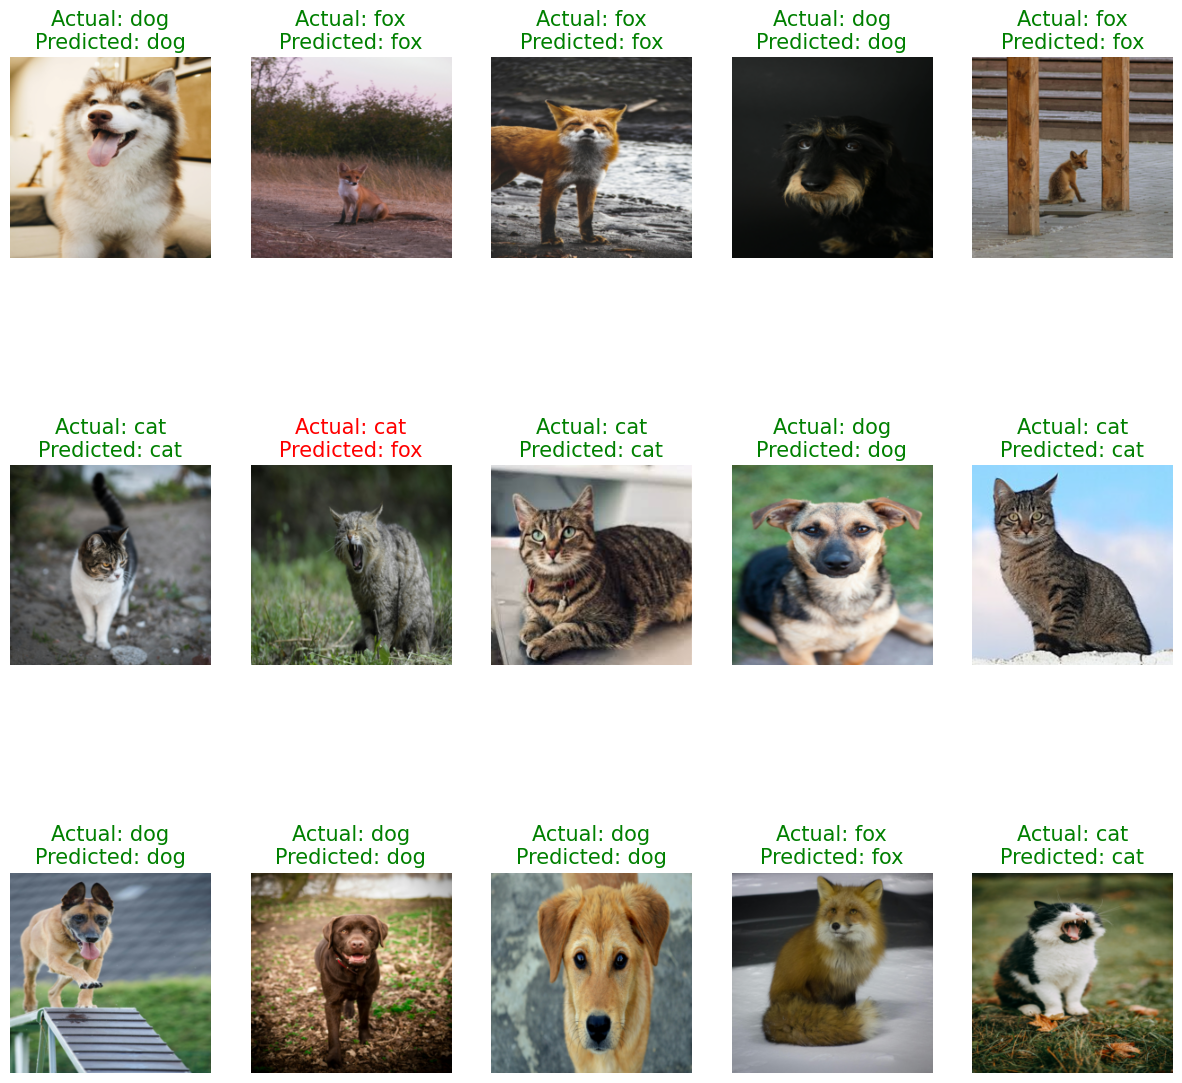

In [38]:
# визуализация
class_names = train_dataset.dataset.classes if isinstance(train_dataset, torch.utils.data.Subset) else train_dataset.classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

plt.figure(figsize=(15, 15))
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        for i in range(15):  
            ax = plt.subplot(3, 5, i + 1)
            image = images[i].cpu()
            npimage = np.transpose(image.numpy(), (1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            denormalized_img = std * npimage + mean
            plt.imshow(denormalized_img)

            predicted_class_idx, confidence = predict(model, image.numpy())
            actual_class_idx = labels[i]
            
            predicted_class = class_names[predicted_class_idx]
            actual_class = class_names[actual_class_idx]
            
            # цвет заголовка в зависимости от того, правильное ли предсказание
            label_color = 'green' if actual_class == predicted_class else 'red'

            plt.title(f'Actual: {actual_class}\nPredicted: {predicted_class}', color=label_color, fontsize=15)
            plt.axis("off")
        
        plt.show()
        break